**prerequisite**
1. 지역에 따라서 선호하는 게임 장르가 다를까?
2. 연도별 게임의 트렌드가 있을까?
3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

**Goal**
- 목표 : 다음 분기에 어떤 게임을 설계해야 할까?
- 대상자 : 비데이터 직군

**Columns**
Name : 게임의 이름입니다.
Platform : 게임이 지원되는 플랫폼의 이름입니다.
Year : 게임이 출시된 연도입니다.
Genre : 게임의 장르입니다.
Publisher : 게임을 제작한 회사입니다.
NA_Sales : 북미지역에서의 출고량입니다.
EU_Sales : 유럽지역에서의 출고량입니다.
JP_Sales : 일본지역에서의 출고량입니다.
Other_Sales : 기타지역에서의 출고량입니다.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import *

url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
df = pd.read_csv(url, parse_dates=['Year'], index_col=0)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0,0,0
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0,0,0.01
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,0.02,0
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0,0,0
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0,0.04


**데이터 타입 확인 및 변경**
1. Object : Name, Platform, Genre, Publisher
2. Date(%Y) : Year
3. Float : NA_Sales, EU_Sales, JP_Sales, Other_Sales

(Null값 존재 시, 처리 후 변경 필요)

Year / Genre / Publisher Null값 존재

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         16598 non-null  object
 1   Platform     16598 non-null  object
 2   Year         16327 non-null  object
 3   Genre        16548 non-null  object
 4   Publisher    16540 non-null  object
 5   NA_Sales     16598 non-null  object
 6   EU_Sales     16598 non-null  object
 7   JP_Sales     16598 non-null  object
 8   Other_Sales  16598 non-null  object
dtypes: object(9)
memory usage: 1.3+ MB


In [77]:
# Sales Data 타입 변경
# - Null값이 없음
# - 문자열 존재 가능성 높음
target_columns = df.columns[5:9]
chr_check = pd.DataFrame()

for col in target_columns:
    chr_check[col] = df[col].str.contains('[a-zA-Z]+')

chr_check.any(axis=1).value_counts()

False    15813
True       785
dtype: int64

In [78]:
temp = pd.DataFrame()
for col in target_columns:
    temp[col] = df[col].str.extract(r'([a-zA-Z]+)')
    print(temp[col].unique())

[nan 'K' 'M']
[nan 'M' 'K']
[nan 'K' 'M']
[nan 'M' 'K']


In [79]:
# 문자열 K, M만 있다는 것을 확인
# K는 10^3으로 M은 10^6으로 변경
for col in target_columns:
    df[col] = df[col].replace({'K':'*1e3','M':'*1e6'}, regex=True).map(pd.eval).astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16598 entries, 1 to 16598
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  object 
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  float64
 6   EU_Sales     16598 non-null  float64
 7   JP_Sales     16598 non-null  float64
 8   Other_Sales  16598 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.3+ MB


**2. 데이터 결측치 처리**
1. Year 
2. Publisher [프로젝트 목적에 필요 없기 때문에 처리 가능]
3. Genre 

- 결측치 데이터는 나중에 활용할 가능성이 있으니 따로 저장해둠 
- Table : missing_table


In [80]:
missing = df.isnull().sum().sort_values(ascending = 0)
missing

Year           271
Publisher       58
Genre           50
Name             0
Platform         0
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [81]:
# 결측치 데이터 따로 저장
cond1 = df['Year'].isna() == True
cond2 = df['Publisher'].isna() == True
cond3 = df['Genre'].isna() == True
missing_table = df[ cond1 | cond2 | cond3 ]

In [82]:
# Publisher Null Data 처리
df['Publisher'].fillna('Unknown', inplace=True)

In [ ]:
# Genre Null Data 처리


In [ ]:
# Year Null Data 처리


In [ ]:
# Year 자리 수 처리


In [89]:
# 일단 진행 하기 위해 null값 제거 하고 진행
df.dropna(inplace=True)

In [90]:
df.isnull().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

**지역에 따라서 선호하는 게임 장르가 다를까?**

H0 = 지역과 게임 장르 사이 상관관계가 없다.
H1 = 지역과 게임 장르 사이 상관관계가 있다.

- 위와 같은 가설 검증을 위해 Chisquare를 이용한다.
- H1 채택시 국가별 장르 선호도를 확인 해본다.

In [215]:
p1_table = df.loc[:,['Genre','NA_Sales','EU_Sales','JP_Sales','Other_Sales']]

grouped_p1 = p1_table.groupby('Genre')
# grouped_p1.reset_index(inplace=True)
marketsize =  grouped_p1.sum()
marketsize

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,21470837.31,7030506.61,1440155.17,1340182.65
Adventure,760101.16,190063.52,80051.81,280016.42
Fighting,1360218.99,1420098.48,1340085.80,500035.65
Misc,4090396.20,2820207.38,420103.76,460072.28
Platform,5220440.16,7620193.03,790129.74,480050.97
Puzzle,80121.50,410050.07,56.24,50012.39
Racing,11950342.75,2040232.99,280056.04,420076.09
Role-Playing,1600317.16,1610181.49,11780331.15,1620055.11
Shooter,12430562.05,6120304.11,60038.12,740101.12


In [216]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(grouped_p1.mean())
msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))

Test Statistic: 49258.8781647331
p-value: 0.0
Degree of Freedom: 33


In [217]:
col = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales']
ind = grouped_p1.indices

scaler = StandardScaler()
Z_sum = pd.DataFrame(scaler.fit_transform(grouped_p1.sum()), columns=col, index=ind)
Z_mean = pd.DataFrame(scaler.fit_transform(grouped_p1.mean()), columns=col, index=ind)

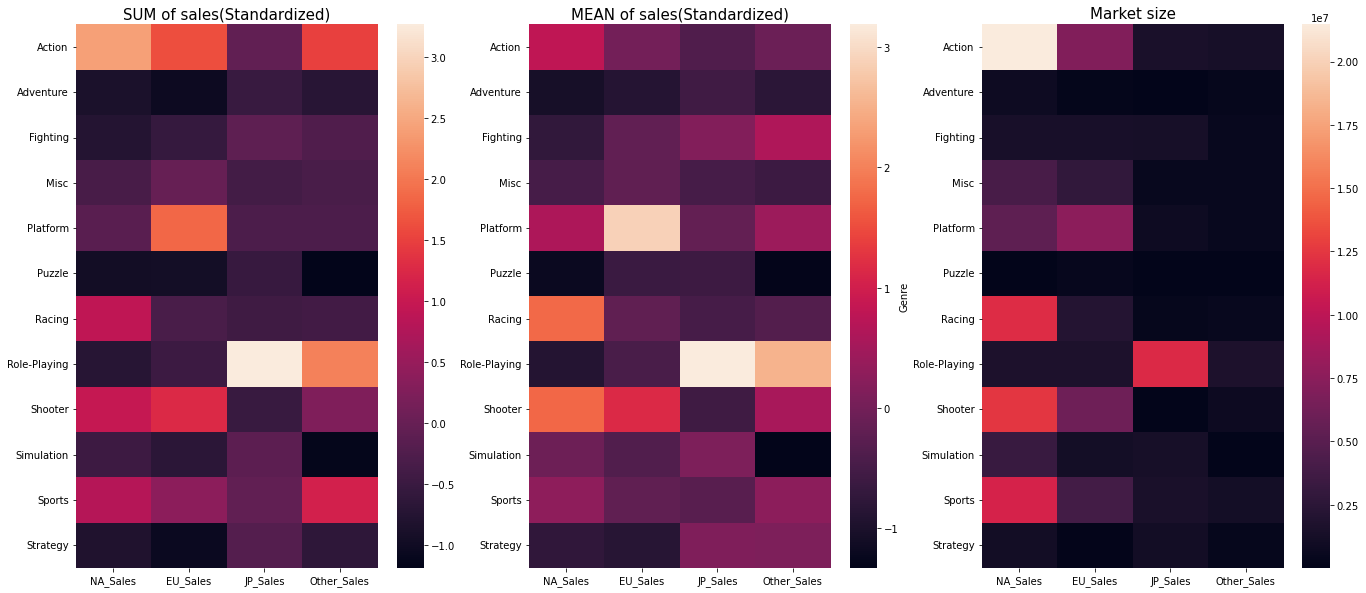

In [218]:
plt.figure(figsize=(23,10))
plt.subplot(131)
plt.title('SUM of sales(Standardized)', fontdict={'size':15})
sns.heatmap(Z_sum)
plt.subplot(132)
plt.title('MEAN of sales(Standardized)', fontdict={'size':15})
sns.heatmap(Z_mean)
plt.subplot(133)
plt.title('Market size', fontdict={'size':15})
sns.heatmap(marketsize)
plt.show()


<AxesSubplot:title={'center':'Market size by genre'}, xlabel='variable', ylabel='value'>

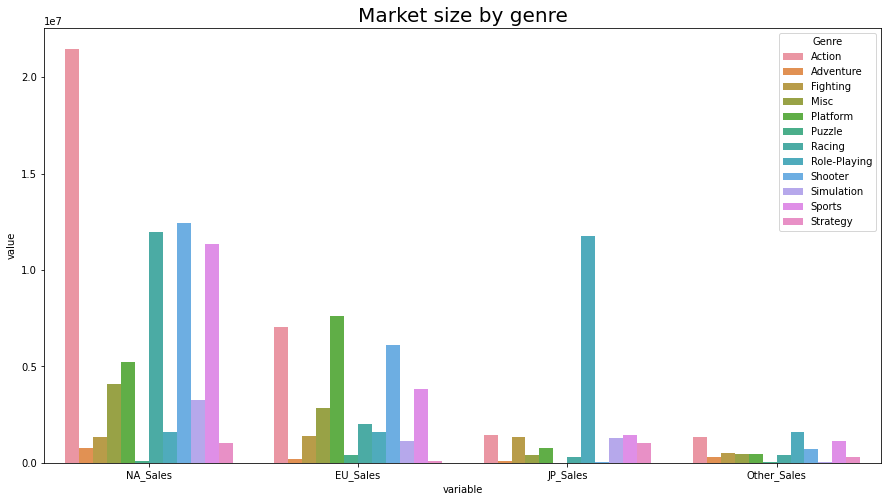

In [219]:
marketsize.reset_index(inplace=True)
melted_ = marketsize.melt(id_vars='Genre', value_vars=['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
plt.figure(figsize=(15,8))
plt.title('Market size by genre', fontdict={'size':20})
sns.barplot(data=melted_, x='variable', y='value', hue='Genre')

ANS 1. 지역과 장르와의 관계에 있어 연관성이 있음 (p-value 0.05이하)
    2. 전반적으로 북미 시장이 타지역보다 잘 형성이 되어 있다.
    - 북미 : 액션, 레이싱, 슈팅, 스포츠에서 매출이 많이 나왔으며, 관심도는 레이싱과 슈팅가 높다고 볼 수 있다. 
    - 유럽 : 액션, 플랫폼, 슈팅, 스포츠에서 매출이 많이 나왔으며, 플랫폼과 슈팅 게임에 대한 관심도가 높다고 볼 수 있다.
    - 일본 : 롤플레잉 게임에 집중 되어있으며, 그 외 스포츠, 액션, 슈팅게임 정도가 활성화 되어 있다.
    - 그 외의 국가들은 시장의 규모가 작으나, 그 중에서도 롤플레잉에 집중도가 높다고 볼 수 있다.

**연도별 게임의 트렌드가 있을까?**

H0 : 연도별 게임의 트렌드가 없다.
H1 : 연도별 게임의 트렌드가 있다.